In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from functools import reduce

π = np.pi

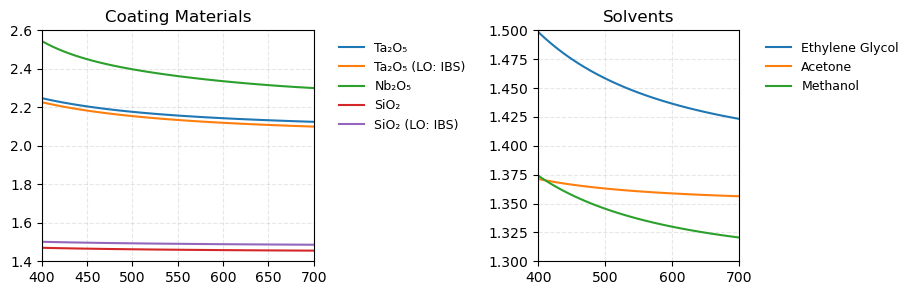

In [8]:
def abs2(x: ArrayLike):
    return np.real(x)**2 + np.imag(x)**2 if np.iscomplexobj(x) else x**2


def sellmeier(B: ArrayLike, C: ArrayLike, λ: float) -> float:
    """
    B, C: ArrayLike
        Sellmeier coefficients (typically of size 3)
    λ: float
        wavelength in um
    """
    B, C = np.array(B), np.array(C)
    return np.sqrt(1 + sum(B*λ**2 / (λ**2 - C)))


def n_refr(material: str | float, λ: float) -> float:
    """
    Returns the refractive index of the given material

    material: str
        material name
    λ: float
        wavelength in nm
    SiO2: https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    Ta2O5: https://refractiveindex.info/?shelf=main&book=Ta2O5&page=Gao
    """
    λ /= 1000 # nm to μm

    # convenience functionality
    if isinstance(material, (float, int)):
        return material
    
    match material:
        case "SiO2:IBS": # With IBS, values from Laseroptik
            B = [1.19261271,   0.5415, 0]
            C = [0.0079968567, 61.257, 0]
            return sellmeier(B, C, λ)
        case "Ta2O5:IBS": # With IBS, values from Laseroptik
            B = [2.63437,   0.5694, 0.243937]
            C = [0.0355851, 0,      81]
            return sellmeier(B, C, λ)
        case "NBK7":
            B = [1.03961212,    0.231792344,  1.01046945]
            C = [0.00600069867, 0.0200179144, 103.560653]
            return sellmeier(B, C, λ)
        case "Suprasil": # Heraeus 
            B = [0.473115591, 0.631038719,  0.906404498]
            C = [0.012995717, 0.0041280922, 98.7685322]
            return sellmeier(B, C, λ)
        case "SiO2":
            B = np.array([0.6961663, 0.4079426, 0.8974794])
            C = np.array([0.0684043, 0.1162414, 9.8961610])
            return np.sqrt(1 + sum(B*λ**2/(λ**2-C**2))) # Not the Sellmeier formular! --> C[i]²
        case "Ta2O5": # values empiric from fit (exponential + polynomial) to data
            return 6.70419*np.exp(-11.1521*λ) + 2.27472 - 0.319763*λ + 0.144455*λ**2
        case "Nb2O5": # values empiric from fit (exponential + polynomial) to data, only valid between 400...800nm
            return 582.098*np.exp(-22.1463*λ) + 2.94173+ -1.58087*λ + 0.948068*λ**2
        case "EthyleneGlycol" | "Ethylenglykol" | "EthGly" | "EthyGly":
            return 1.386820 + 17856.021e-6 * λ**(-2)
        case "Acetone" | "Aceton":
            return 1.34979 + 0.00306*λ**-2 + 0.00006*λ**-4
        case "Methanol":
            return 1.294611 + 12706.403e-6*λ**-2
        case "Octadecence":
            return 1.44
        case "Air" | "Vac" | "Vacuum" | "Vacuume":
            return 1.00
        case _:
            ValueError(f"Material {material} not recognized")


λ = np.linspace(400, 700)
plt.figure(figsize=(9, 3))
plt.subplot2grid((1, 10), (0, 0), colspan=4, title="Coating Materials", xlim=(400, 700), ylim=(1.4, 2.6))
plt.plot(λ, [n_refr("Ta2O5", wlen)     for wlen in λ], label="Ta₂O₅")
plt.plot(λ, [n_refr("Ta2O5:IBS", wlen) for wlen in λ], label="Ta₂O₅ (LO: IBS)")
plt.plot(λ, [n_refr("Nb2O5", wlen)     for wlen in λ], label="Nb₂O₅")
plt.plot(λ, [n_refr("SiO2", wlen)      for wlen in λ], label="SiO₂")
plt.plot(λ, [n_refr("SiO2:IBS", wlen)  for wlen in λ], label="SiO₂ (LO: IBS)")
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.6, 1), frameon=False)

plt.subplot2grid((1, 10), (0, 7), colspan=3, title="Solvents", xlim=(400, 700), ylim=(1.3, 1.5))
plt.plot(λ, [n_refr("EthGly", wlen)    for wlen in λ], label="Ethylene Glycol")
plt.plot(λ, [n_refr("Acetone", wlen)   for wlen in λ], label="Acetone")
plt.plot(λ, [n_refr("Methanol", wlen)  for wlen in λ], label="Methanol")
plt.xlim(400, 700)
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.85, 1), frameon=False)

In [38]:
def generate_bragg_mirror_Stack(λ0: float, m_high: str | float, m_low: str | float, N: int, topLayer: bool) -> np.ndarray:
    """
        create layer stack with individual thickness of λ/4
        returns array of layer thicknesses

        Examples:
        - CRD: N=13, Nb2O5, SiO2
        - LO550: N=19, Ta2O5, SiO2
    """
    n1, n2 = n_refr(m_high, λ0*1e9), n_refr(m_low, λ0*1e9)
    n = np.tile([n1, n2], N)

    # add another high `n` layer on top
    if topLayer == True:
        n = np.append(n, n1)

    return λ0 / (4*n) # Thickness: λ/4


def get_custom_layer_stack(m_high: str | float, m_low: str | float) -> np.ndarray:
    """
        lengths are given in units of λ/4
        reverse order because Laseroptik company provides data from substrate side

        returns array of custom layer thicknesses
    """

    #----- Smoothing of transmission: Final
    # λ0 = 570e-9 # design wavelength
    # d = λ0 * np.array([1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604,1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    
    #----- Zero degree 2021
    λ0 = 577e-9 # design wavelength
    d = λ0 * np.array([0.93606,0.93021,0.94428188025,0.8793,0.67386,0.21653,0.92916,0.85924,0.88793,0.81784,0.82287,0.82589,0.89287,0.87968,0.93094,0.92011,0.98763,1.37457,1.37032,0.94265,0.96662,0.92173,0.91545,0.88216,0.87477,0.85617,0.91143,0.89408,0.9286,0.92307,1.65457,1.004129603043,0.97952,0.9476,0.96056,0.96055,0.97354,0.94413,0.96186,0.97716,0.9836,1.02031,1.22784,1.23484,1.05889,1.00925,0.99314,2.802,1.062])
        
    #----- Trying stuff with Nb2O5
    # d = reverse(550e-9 * vcat(repeat([1.35,], 28), repeat([1.0,], 29)))

    d = np.flip(d) # reverse for correct order
    
    n1, n2 = n_refr(m_high, λ0*1e9), n_refr(m_low, λ0*1e9)
    n = np.tile([n1, n2], len(d)//2 + 1)[1:len(d)] # alternating refractive indices. Truncate last element if length(d) is odd
    n = np.flip(n)

    return d / (4*n) # λ/4 stacks


def transmission_of_dielectric_mirror(λ: float, θ0: float, d: ArrayLike, medium: float | str, substrate: float | str, m_high: float | str, m_low: float | str) -> tuple[float]:
    """
        Transmission of a lossless dielectric mirror with custom layer structure, adapted from DOI: 10.1364/AO.47.00C219

        The effect of the mirror substrate backside is untrivial as it depends if the reflections have to be treated (in-)coherently
        To my understanding, the shown calculations are for a semi-infinite substrate thickness.

        Args:
            λ: float
                Wavelength (in vacuume)
            θ0: float
                Incidence angle
            d: ArrayLike:
                Array of layer thicknesses
            medium, substrate: float | str
                materials above and below the layer stack
            m_high, m_low: float | str
                Materials with alternating high and low refractive index

        returns: (float, float)
            transmission coefficients of s- and p-pol
    """
    θ0 = np.deg2rad(θ0)
    n0, ns, n1, n2 = n_refr(medium, λ*1e9), n_refr(substrate, λ*1e9), n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    n = np.tile([n1, n2], len(d)//2 + 1)[:len(d)] # alternating refractive indices. Truncate last element if len(d) is odd

    # total internal reflection, T = 0
    if n0 * np.sin(θ0) > ns:
        return 0.0, 0.0

    θ = np.arcsin(n0/n * np.sin(θ0)) # propagation angle inside the layers
    θ_out = np.arcsin(n0/ns * np.sin(θ0)) # propagation angle inside substrate

    δ = 2*π/λ * n*d * np.cos(θ) # phase shift per layer, δ = k*d*cos(θ)
    # refractice pseudo-indices
    η0_s, ηs_s, η_s = n0 * np.cos(θ0), ns * np.cos(θ_out), n * np.cos(θ)
    η0_p, ηs_p, η_p = n0 / np.cos(θ0), ns / np.cos(θ_out), n / np.cos(θ) 
    # Transfer-Matrices for s- and p-pol.
    # Tranposing: δ and η are arrays and will fill each matrix element with a lot of values. But we want an array of 2x2 matrices, hence we have to reorganize. Typical numpy hassle...
    M_s = np.array([[np.cos(δ),          1j*np.sin(δ)/η_s],
                    [1j*np.sin(δ)*η_s,   np.cos(δ)]       ]).transpose(2, 0, 1)
    M_p = np.array([[np.cos(δ),          1j*np.sin(δ)/η_p],
                    [1j*np.sin(δ)*η_p,   np.cos(δ)]       ]).transpose(2, 0, 1)
    
    # Calculation for s- and p-polarization separately
    v1_s, v2_s = [[η0_s, -1], [η0_s, 1]] @ reduce(np.matmul, M_s) @ [1, ηs_s] # slow
    R_s = abs2(v1_s/v2_s)

    v1_p, v2_p = [[η0_p, -1], [η0_p, 1]] @ reduce(np.matmul, M_p) @ [1, ηs_p] # slow
    R_p = abs2(v1_p/v2_p)

    return 1 - R_s, 1 - R_p

In [78]:
λ = np.arange(450.0, 650.0, 1)
λ0 = 550
θ = np.arange(0, 90, 1)

d = generate_bragg_mirror_Stack(λ0*1e-9, "Nb2O5", "SiO2:IBS", N=13, topLayer=True)
# s- and p-polarization
# To properly unpack into (T_s, T_p) we `transpose()` to bring the polarization axis from the back to the front.
T_s, T_p = np.array([[transmission_of_dielectric_mirror(λ_*1e-9, θ_, d, medium="EthGly", substrate="SiO2", m_high="Nb2O5", m_low="SiO2:IBS") for λ_ in λ] for θ_ in θ]).transpose((2, 0, 1))
T = (T_s + T_p)/2 # full transmission
T_s.shape

(90, 200)

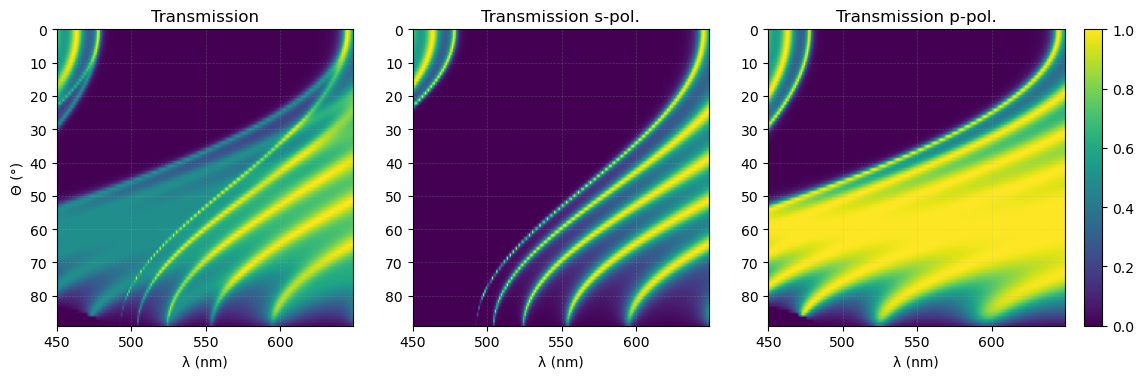

In [77]:
imshow_obj = None
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for (ax, Trans, t) in zip(axs, [T, T_s, T_p], ["Transmission", "Transmission s-pol.", "Transmission p-pol."]):
    imshow_obj = ax.imshow(Trans,
        extent = (λ.min(), λ.max(), θ.max(), θ.min()),
        aspect = (λ.min() - λ.max())/(θ.min() - θ.max()),
        vmin = 0, vmax = 1, cmap="viridis"
    )
    ax.set(xlabel="λ (nm)", title=t)
    ax.grid(ls="--", alpha=0.25, lw=0.5)
axs[0].set_ylabel("Θ (°)")
# custom colorbar
cax = fig.add_axes([axs[2].get_position().x1+0.015, axs[2].get_position().y0, 0.014, axs[2].get_position().height]) # x, y, width, height
plt.colorbar(imshow_obj, cax=cax)
# plt.savefig("out/CRD550_EthGly.pdf", dpi=300)

In [43]:
angle_idx = np.argmin(abs(θ - 42)) # Angle close to...
λ_idx = np.argmin(abs(λ - 532)) # which wavelength
scale = "log"

Tₘᵢₙ(θ=42°) = 2.62e-08


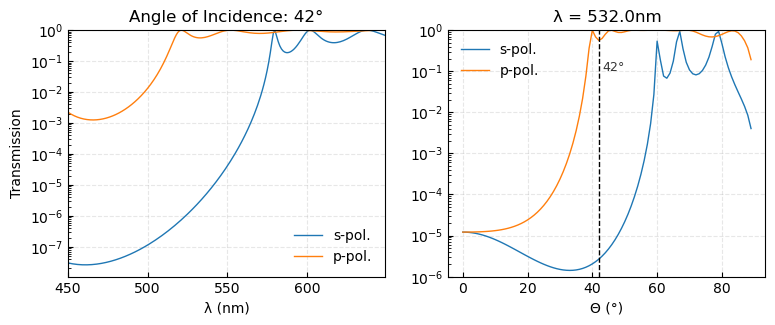

In [44]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121, title=f"Angle of Incidence: {θ[angle_idx]}°", xlabel="λ (nm)", ylabel="Transmission")
plt.yscale("log" if scale == "log" else "linear")
plt.plot(λ, T_s[angle_idx, :], lw=1, label="s-pol.")
plt.plot(λ, T_p[angle_idx, :], lw=1, label="p-pol.")
# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3)
plt.xlim(λ.min(), λ.max())
plt.ylim(None, 1)
plt.legend(frameon=False)
plt.gca().tick_params(which="both", direction="in")
print(f"Tₘᵢₙ(θ={θ[angle_idx]}°) = {np.min(T_s[angle_idx, :]):.2e}")

plt.subplot(122, title=f"λ = {λ[λ_idx]}nm", xlabel="Θ (°)")
plt.yscale("log" if scale == "log" else "linear")
plt.plot(θ, T_s[:, λ_idx], lw=1, label="s-pol.")
plt.plot(θ, T_p[:, λ_idx], lw=1, label="p-pol.")
plt.grid(ls="--", alpha=0.3)
plt.axvline(θ[angle_idx], lw=1, ls="--", color="k")
plt.text(θ[angle_idx] + 0.012*abs(np.diff(plt.xlim())), 0.1, f"{θ[angle_idx]}°", fontsize=9, alpha=0.8) # degree number at vline
plt.ylim(1e-6, 1)
plt.gca().tick_params(which="both", direction="in")
plt.legend(frameon=False)
# plt.tight_layout(); plt.savefig("out/HT532.pdf")

# Plot 3D Transmission of an Optical Resonator using the specified Mirrors as a function of Incidence Angle

C:\Users\Erik\AppData\Local\Temp\ipykernel_3580\1269266315.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


Text(0, 0.5, 'Average Transmission')

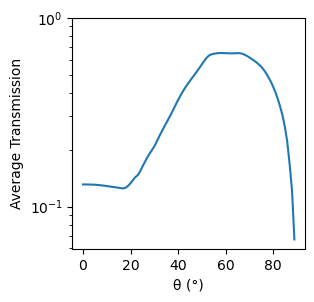

In [91]:
# Losses(λ, Θ) = ∫ T(λ, Θ) * f(λ)  sin(Θ)dΘ dλ
losses = np.mean(T, axis=1)

# R6G_ems = np.loadtxt("res/rhodamine6G.abs.ems.dat", usecols=(0, 2))
# λ_ref, ems = R6G_ems[:, 0], R6G_ems[:, 1]

plt.figure(figsize=(3, 3))
plt.yscale("log")
plt.plot(θ, losses)
# plt.plot(λ_ref, ems)
plt.ylim(1e-2, 1)
# plt.grid(color="lightgray", ls="--", lw=1)
plt.xlabel("θ (°)")
plt.ylabel("Average Transmission")

Min: 0.2830905281558014, Max: 0.8661081028753743


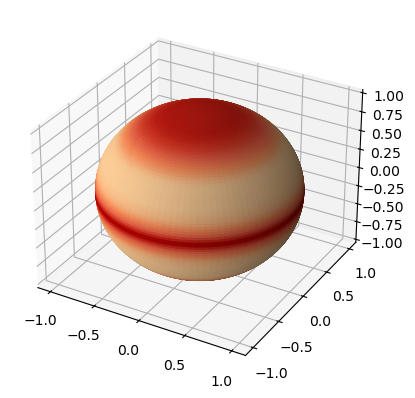

In [99]:
theta, phi = np.linspace(0, π, 100), np.linspace(0, 2*π, 100)
theta, phi = np.meshgrid(theta, phi)
x, y, z = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)

surface_1 = np.interp(np.rad2deg(theta), θ, losses)
surface_2 = np.interp(np.rad2deg(π - theta), θ, losses)

fcolors = 1 - (surface_1 + surface_2)
print(f"Min: {fcolors.min()}, Max: {fcolors.max()}")
fmax, fmin = 1, 0 # fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.OrRd(fcolors))
#ax.set_axis_off()